<a href="https://colab.research.google.com/github/Yunyi-learner/Yunyi-s-Homepage/blob/main/Latent_NeuralODE_for_Functional_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
GDRIVE_ROOT = "/content/gdrive/My Drive"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Latent Neural ODE for Functional Data

In this toy experiment, I generated true data for each individual i based on a pre-defined function:
$$
X_{i1}(s) = ∑_{l=1}^{E_s} \left \{v_{ik_1}sin(k\pi s/5) + v_{ik_2} cos(k \pi s /5)\right \} + \beta C_{i}
$$

where $E_s=2$ and $v_{ik_1}, v_{ik_2} \sim N(0, 1/k^4)$ are independent across subjects i. $C_i$ is covariate following discrete uniform distribution.

For observed data, Guassian noise was added:
$$
V_{i1}(s)= X_{i1}(s)+\delta_{i1}(s)
$$
where $\delta_{i1}(s)\sim N(0,\sigma_X^2)$.

Importing packages:

In [2]:
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Install torchdiffeq package

In [3]:
# !git clone https://github.com/rtqichen/torchdiffeq.git

In [4]:
! pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Hyperparameter settings:

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument('--adjoint', type=eval, default=False)
parser.add_argument('--visualize', type=eval, default=True)
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--lr', type=float, default=0.01)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--train_dir', type=str, default=None)
args = parser.parse_args([])

if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

# Defined module to generate data


In [6]:
# let's try one predictor first
def generate_yx1x2(n=200, # number of subjects
		               nx1=50, # number of grids on which X1(s) predictor curves are observed
                   nsamplex1=50,
		               sstart=0.1,
		               sstop=5,
                   varX1=0.2**2,
                   beta=0.5, # the parameter for covariate
                   savefig=True):

    """
    Args:
      n: number of subjects
      nx1: number of grids on which X1(s) predictor curves are observed
      nsamplex1: number of sampled x1 for model fitting per subject
      sstart: X1 curve starting time
      sstop: X1 curve ending time
      varX1: variance of X1 noise
      savefig: plot the ground truth for sanity check

    Returns:
      Tuple where first element is true trajectory of size (n, nx1),
      second element is noisy observations of size (n, nsamplex1),
      third element is timestamps of size (nx1,),
      and fourth element is timestamps of size (nsamplex1,)
    """
    # set seed later
    # intercept
    by = 0.1
    s = np.arange(sstart,sstop+by,by)
    # skip matrices initialization
    ###---------------------X1 funct pred -----------------------###
    ###----------------------- mean 0 ---------------------------###
    ###----------------- adapted from Goldsmith -----------------###
    funcs1_true=np.zeros((n,s.size))
    for i2 in range(0,n):
        for j2 in range(1,3):
            e=np.random.normal(0,(1/j2**2),2)
            funcs1_true[i2,]=funcs1_true[i2,]+e[0]*np.cos((2*np.pi/10)*s*j2)
            funcs1_true[i2,]=funcs1_true[i2,]+e[1]*np.sin((2*np.pi/10)*s*j2)
    X1=funcs1_true

   # plot trajectories without adding beta*Ci for all subjects
    if savefig:
        plt.figure()
        for n1 in range(0,n):
            plt.plot(s, X1[n1,:])
        plt.title('X1 truth without covariate')
        plt.savefig('./X1_truth.png')
        plt.show()
        plt.close()
        print('Saved X1 {}'.format('./X1_truth.png'))

    # sample starting timestamps
    samp_s_idx = npr.choice(range(0,s.size),(nsamplex1),replace = False)
    samp_s_idx.sort()
    samp_s = s[samp_s_idx]
    # samp_s = s[:s.size]

    orig_trajs = []
    samp_trajs = []
    ccs = []
    for _ in range(n):
        cc = npr.randint(1,3)
        ccs.append(cc)
        beta = beta # we can ignore the influence of covariate by assigning beta = 0
        orig_traj = X1[_,:]+beta*cc
        orig_trajs.append(orig_traj)
        samp_traj = orig_traj[samp_s_idx].copy()
        samp_traj += npr.randn(*samp_traj.shape) * np.sqrt(varX1)
        samp_trajs.append(samp_traj)

    # plot trajectories adding beta*Ci for all subjects
    plt.figure()
    for n1 in range(0, n):
        plt.plot(s,orig_trajs[n1])
    plt.title('X1 truth with covariate')
    plt.savefig('./X1_truth_cov.png')
    plt.show()
    plt.close()
    print('Saved X1 {}'.format('./X1_truth_cov.png'))

    # plot one subject's observed data point with true trajectory
    plt.figure()
    plt.scatter(samp_s, samp_trajs[0])
    plt.title('X1 One subjects observations')
    plt.savefig('./X1_observed.png')
    plt.show()
    plt.close()
    # batching for sample trajectories is good for RNN; batching for original
    # trajectories only for ease of indexing
    orig_trajs = np.stack(orig_trajs, axis=0)
    samp_trajs = np.stack(samp_trajs, axis=0)

    orig_s=s
    return orig_trajs, samp_trajs, orig_s, samp_s, ccs

# Define Neural Network for ODE function
In this experiment, Neural ODE is used to model the dynamic change of latent state.

In [7]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


# RNN Recognition Model
Recurrent neural network is used to recognize the initial value of latent state. 

Those initial values will be used to fit the whole dynamic change of latent state together with the solution of neural ODE.

In [8]:

class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=1, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)


# Decoder Model
Another neural network is used to decode the latent state to observed values

In [9]:

class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=1, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Covariate Model
Another neural network with covariates input is added to get parameters of covariates which we are really interested in


In [10]:

class Covariates(nn.Module):

    def __init__(self, cov_dim=1, obs_dim=1):
        super(Covariates, self).__init__()
        self.fc = nn.Linear(cov_dim,obs_dim,bias=False)
        # self.fc.weight.data.fill_(0.)
        for m in self.fc.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=1)
    def forward(self,x,c):
        out = self.fc(c)
        out = torch.add(out,x)
        return out

Parameters optimization settings

In [11]:

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


# ELBO
Generally speaking, we have:
$$
\mathbf{z}_{t_0} \sim p(\mathbf{z}_{t_0}) \\
\mathbf{z}_{t_1}, \mathbf{z}_{t_2},\ldots, \mathbf{z}_{t_N} = ODESolver(\mathbf{z}_{t_0},f,\theta_f,t_0,\ldots ,t_N) \\
\mathbf{x}_{t_i}\sim p(\mathbf{x}|\mathbf{z}_{t_i},\theta_x)
$$

We cannot get a closed-form of the posterior distribution $p(z_{t_0}|x_{t_0},\ldots,x_{t_N})$, but we can find a simple and tractable surrogate distribution $q(z_{t_0})$ from family $Q$ by optimization of Kullback-Leibler (KL) divergence.
$$
q^*(z_{t_0}) = arg min_{q^*(z_{t_0})\in Q}D_{KL}[q(z_{t_0})||p(z_{t_0}|\mathbf{x})]
$$

According to the definition of KL distance, we can have:
\begin{align}
KL(q(z_{t_0})||p(z_{t_0}|{x})) 
&= \int_{z_{t_0}}q(z_{t_0})log\frac{q(z_{t_0})}{p(z_{t_0}|x)}dz_{t0} \\
&= \int_{z_{t_0}}q(z_{t_0})log\frac{q(z_{t_0})p(x)}{p(z_{t_0},x)}dz_{t0} \\
&=- E_{z_{t_0}\sim q(z_{t_0})} log\frac{p(z_{t_0},x)}{q(z_{t_0})}+logp(x)\\
&=-L(q)+log p(x) \\
&=-ELBO + logp(x) \\
&\Rightarrow \\ 
logp(x) &= KL(q(z_{t_0})||p(z_{t_0}|{x})) + ELBO \text{ (since KL is non-negative)} \\
&\geq ELBO \text{ (The Evidence Lower Bound)}
\end{align}

So the optimization of ELBO is equivalent to the $KL(q(z_{t_0})||p(z_{t_0}|\mathbf{x}))$.  

\begin{align}
ELBO &= E_{z_{t_0}\sim q(z_{t_0})} log\frac{p(z_{t_0},x)}{q(z_{t_0})} \\ 
&= E_{z_{t_0}\sim q(z_{t_0})} log\frac{p(x|z_{t_0})p(z_{t_0})}{q(z_{t_0})} \\
& = E_{z_{t_0}\sim q(z_{t_0})}logp(x|z_{t_0})-E_{z_{t_0}\sim q(z_{t_0})}log \frac{q(z_{t_0})}{p(z_{t_0})} \\
&=logp(x|z_{t_0})-KL(q(z_{t_0})||p(z_{t_0}))
\end{align}

In our experiment, specifically:
$$
\mathbf{z}_{t_0} \sim p(\mathbf{z}_{t_0})\sim N(0,0) \\
\mathbf{z}_{t_1}, \mathbf{z}_{t_2},\ldots, \mathbf{z}_{t_N} = ODESolver(\mathbf{z}_{t_0},f,\theta_f,t_0,\ldots ,t_N) \\
x_{t_i}\sim p(x_{t_i}|z_{t_i},\theta_x) \sim N(\mu_{t_i} = decoder_{\theta_x}(z_{t_i}),\sigma_{t_i}^2)
$$

By the assumption of $p(x_{t_i}|z_{t_i})\sim N(\mu_{t_i},\sigma_{t_i}^2)$, we can derive $logp(x_{t_i}|z_{t_i})$
\begin{align}
& p(x_{t_i}|z_{t_i}) = \frac{1}{\sqrt{2 \pi \sigma_{t_i}^2}}exp\left\{-\frac{1}{2\sigma_{t_i}^2}(x_{t_i}-\mu_{t_i})^2\right\}  \\ 
& \Rightarrow \\ 
& log p(x_{t_i}|z_{t_i}) = -\frac{1}{2} \left \{log(2\pi)+\log\sigma_{t_i}^2+\frac{1}{\sigma_{t_i}^2}(x_{t_i}-\mu_{t_i})^2\right\} \\ 
\end{align}
which defined as function "log_normal_pdf" below.

\begin{align}
KL(q(z_{t_0})||p(z_{t_0})) &= E_{z_{t_0}\sim q(z_{t_0})}log \frac{q(z_{t_0})}{p(z_{t_0})} \\
&= E_{z_{t_0}\sim q(z_{t_0})}-\frac{1}{2}\left\{log\sigma_q^2 - log \sigma_p^2
+ \frac{1}{\sigma_q^2}(z_{t_0}-\mu_q)^2 - \frac{1}{\sigma_p^2}(z_{t_0}-\mu_p)^2 \right\} \\ 
&=\left \{\frac{log \sigma_p^2}{2}-\frac{log \sigma_q^2}{2}\right \}-0.5 +E_{z_{t_0}\sim q(z_{t_0})}\frac{(z_{t_0}-\mu_p)^2}{2\sigma_p^2} \\ 
& =\left \{\frac{log \sigma_p^2}{2}-\frac{log \sigma_q^2}{2}\right \}-0.5 +E_{z_{t_0}\sim q(z_{t_0})} \frac{(z_{t_0}-\mu_q)^2+\mu_p^2-\mu_q^2-2z_{t_0}\mu_p+2z_{t_0}\mu_q}{2\sigma_p^2} \\ 
& = \left \{\frac{log \sigma_p^2}{2}-\frac{log \sigma_q^2}{2}\right \}+ 
\frac{\sigma_q^2 + (\mu_q-\mu_p)^2}{2\sigma_p^2}-0.5
\end{align}

which defined as function "normal_kl" below.

Functions for Caculating ELBO loss function

In [12]:

def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

# Main Process
In this training process, I defined two optimizing strategies:

1.   optimizer: fix (lr=0) covariates parameters when training neural network parameters
2.   optimizer_cov: fix (lr=0) neural network parameters when training covariate parameters

In the "try" section we can arbitrary design how we would love to train those parameters.
For example here, I designed 10 training blocks, within each training block, 
we fix beta and train neural nework parameters for 5 epochs, 
then fix neural nework parameters and train beta for another 5 epochs.

I also print out beta parameter, part of neural ODE parameters and part of decoder parameters during the training. It can be easily seen that, the training process follows our designed training strategies very well.

Note: For demonstration purpose, I only set very small number of iterations, so the fitting results are not quite good.


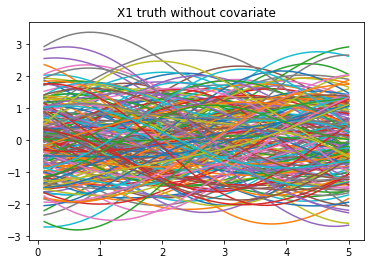

Saved X1 ./X1_truth.png


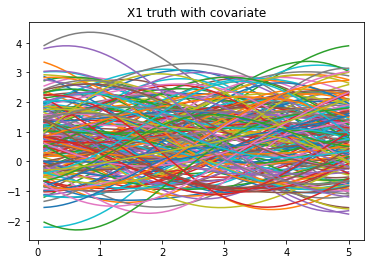

Saved X1 ./X1_truth_cov.png


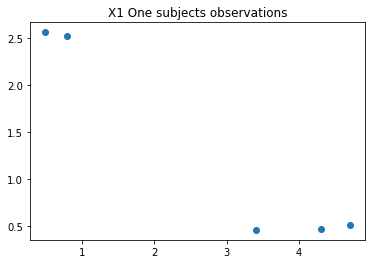

 Beta parameter: tensor([[0.3072]]),
 Neural ODE parameters: tensor([ 0.2957,  0.1989,  0.3447, -0.0772]),
 Decoder parameters: tensor([ 0.1662,  0.2414,  0.2977, -0.4295])
NN, Iter block: 1, Iter: 1, running avg elbo: -316.3747
 Beta parameter: tensor([[0.3072]]),
 Neural ODE parameters: tensor([ 0.2945,  0.1952,  0.3350, -0.0719]),
 Decoder parameters: tensor([ 0.1604,  0.2371,  0.2881, -0.4340])
NN, Iter block: 1, Iter: 2, running avg elbo: -316.2897
 Beta parameter: tensor([[0.3072]]),
 Neural ODE parameters: tensor([ 0.2921,  0.1948,  0.3268, -0.0673]),
 Decoder parameters: tensor([ 0.1537,  0.2372,  0.2803, -0.4359])
NN, Iter block: 1, Iter: 3, running avg elbo: -316.1051
 Beta parameter: tensor([[0.3072]]),
 Neural ODE parameters: tensor([ 0.2904,  0.1930,  0.3210, -0.0647]),
 Decoder parameters: tensor([ 0.1491,  0.2366,  0.2749, -0.4381])
NN, Iter block: 1, Iter: 4, running avg elbo: -315.8226
 Beta parameter: tensor([[0.3072]]),
 Neural ODE parameters: tensor([ 0.2883,  0.192

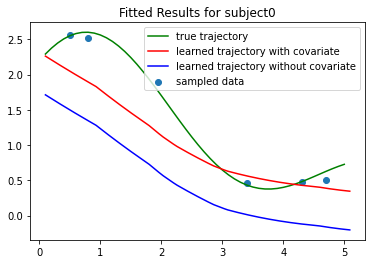

Saved visualization figure at ./vis0.png
tensor([[1.]])


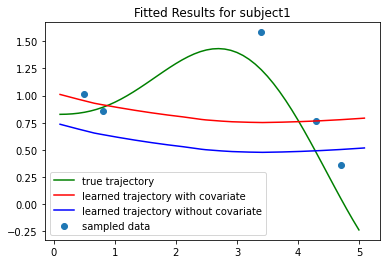

Saved visualization figure at ./vis1.png
tensor([[1.]])


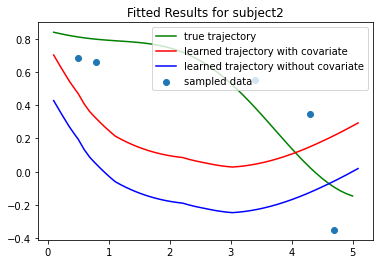

Saved visualization figure at ./vis2.png
tensor([[2.]])


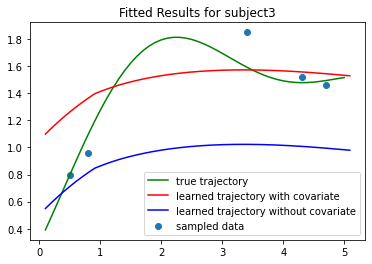

Saved visualization figure at ./vis3.png
tensor([[1.]])


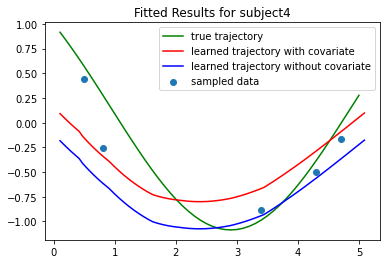

Saved visualization figure at ./vis4.png


In [13]:

if __name__ == '__main__':
    latent_dim = 4
    nhidden = 20
    rnn_nhidden = 25
    obs_dim = 1
    cov_dim = 1
    n = 200
    nx1=50
    nsamplex1=5
    sstart=0.1
    sstop=5
    varX1=0.1**2
    device = torch.device('cuda:' + str(args.gpu)
                          if torch.cuda.is_available() else 'cpu')

    # generate toy spiral data
    orig_trajs, samp_trajs, orig_s, samp_s, ccs = generate_yx1x2(nsamplex1=nsamplex1)
    orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
    samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
    samp_s = torch.from_numpy(samp_s).float().to(device)
    ccs = torch.from_numpy(np.array(ccs)).float().to(device)

    # model
    func = LatentODEfunc(latent_dim, nhidden).to(device)
    rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, n).to(device)
    dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
    cov = Covariates(cov_dim, obs_dim).to(device)
    params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
    cov_params = (list(cov.parameters()))
    loss_meter = RunningAverageMeter()
    # here I defined two optimizing strategies:
    # optimizer: fix (lr=0) covariates parameters when training neural network parameters
    # optimizer_cov: fix (lr=0) neural network parameters when training covariate parameters
    optimizer = optim.Adam([{'params': params}, {'params': cov_params, 'lr': 0.0}], lr=args.lr)
    optimizer_cov = optim.Adam([{'params': params, 'lr': 0.}, {'params': cov_params}], lr=args.lr)

    if args.train_dir is not None:
        if not os.path.exists(args.train_dir):
            os.makedirs(args.train_dir)
        ckpt_path = os.path.join(args.train_dir, 'ckpt.pth')
        if os.path.exists(ckpt_path):
            checkpoint = torch.load(ckpt_path)
            func.load_state_dict(checkpoint['func_state_dict'])
            rec.load_state_dict(checkpoint['rec_state_dict'])
            dec.load_state_dict(checkpoint['dec_state_dict'])
            cov.load_state_dict(checkpoint['cov_state_dict'])
            # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            orig_trajs = checkpoint['orig_trajs']
            samp_trajs = checkpoint['samp_trajs']
            orig_s = checkpoint['orig_s']
            samp_s = checkpoint['samp_s']
            print('Loaded ckpt from {}'.format(ckpt_path))

# In this section we can arbitrary design how we would love to train those parameters
# for example here, I designed 10 training blocks, within each training block, 
# we fix beta and train neural nework parameters for 5 epochs, 
# then fix neural nework parameters and train beta for another 5 epochs.

    try:
        for itrblock in range(1,10):
            for itr in range(1*itrblock, 1*itrblock+5):
            # for itr in range(1,10):
                optimizer.zero_grad()
                optimizer_cov.zero_grad()
                # backward in time to infer q(z_0)
                h = rec.initHidden().to(device)
                for t in reversed(range(samp_trajs.size(1))):
                    obs = samp_trajs[:, t, None]
                    out, h = rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device) #epsilon~N(0,1)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
                # # forward in time and solve ode for reconstructions
                pred_z = odeint(func, z0, samp_s).permute(1, 0, 2)
                pred_x = dec(pred_z)
                pred_x = cov(pred_x, ccs[:,None,None])
                # compute loss
                noise_std_ = torch.zeros(pred_x.size()).to(device) + np.sqrt(varX1)
                noise_logvar = 2. * torch.log(noise_std_).to(device)
                logpx = log_normal_pdf(
                    samp_trajs[:,:,None], pred_x, noise_logvar).sum(-1).sum(-1)
                pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
                analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                        pz0_mean, pz0_logvar).sum(-1)
                loss = torch.mean(-logpx + analytic_kl, dim=0)
                loss.backward()
                optimizer.step()
                loss_meter.update(loss.item())
                print(' Beta parameter: {},\n Neural ODE parameters: {},\n Decoder parameters: {}'
                .format(cov.fc.weight.data, func.fc1.weight.data[0], dec.fc1.weight.data[0]))
                print('NN, Iter block: {}, Iter: {}, running avg elbo: {:.4f}'.format(itrblock, itr, -loss_meter.avg))
            for itr in range(1*itrblock+5, 1*itrblock+10):
                optimizer.zero_grad()
                optimizer_cov.zero_grad()
                # backward in time to infer q(z_0)
                h = rec.initHidden().to(device)
                for t in reversed(range(samp_trajs.size(1))):
                    obs = samp_trajs[:, t, None]
                    out, h = rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean

                # forward in time and solve ode for reconstructions
                pred_z = odeint(func, z0, samp_s).permute(1, 0, 2)
                pred_x = dec(pred_z)
                pred_x = cov(pred_x, ccs[:,None,None])
                # compute loss
                noise_std_ = torch.zeros(pred_x.size()).to(device) + np.sqrt(varX1)
                noise_logvar = 2. * torch.log(noise_std_).to(device)
                logpx = log_normal_pdf(
                    samp_trajs[:,:,None], pred_x, noise_logvar).sum(-1).sum(-1)
                pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
                analytic_kl = normal_kl(qz0_mean, qz0_logvar,
                                        pz0_mean, pz0_logvar).sum(-1)
                loss = torch.mean(-logpx + analytic_kl, dim=0)
                loss.backward()
                optimizer_cov.step()
                loss_meter.update(loss.item())
                print(' Beta parameter: {},\n Neural ODE parameters: {},\n Decoder parameters: {}'
                .format(cov.fc.weight.data, func.fc1.weight.data[0], dec.fc1.weight.data[0]))
                print('Cov, Iter block: {}, Iter: {}, running avg elbo: {:.4f}'.format(itrblock, itr, -loss_meter.avg))

    except KeyboardInterrupt:
        if args.train_dir is not None:
            ckpt_path = os.path.join(args.train_dir, 'ckpt.pth')
            torch.save({
                'func_state_dict': func.state_dict(),
                'rec_state_dict': rec.state_dict(),
                'dec_state_dict': dec.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'orig_trajs': orig_trajs,
                'samp_trajs': samp_trajs,
                'orig_s': orig_s,
                'samp_s': samp_s,
            }, ckpt_path)
            print('Stored ckpt at {}'.format(ckpt_path))
    print('Training complete after {} iters.'.format(itr))

    if args.visualize:
      # generate fitting plots for 20 subjects for visual checking
        for i in range(0, 5):
            with torch.no_grad():
                # sample from trajectorys' approx. posterior
                h = rec.initHidden().to(device)
                for t in reversed(range(samp_trajs.size(1))):
                    obs = samp_trajs[:, t, None]
                    out, h = rec.forward(obs, h)
                qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
                epsilon = torch.randn(qz0_mean.size()).to(device)
                z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
                orig_ts = torch.from_numpy(orig_s).float().to(device)

            # take first trajectory for visualization
                z0 = z0[i]
                by = 0.1
                ts = np.arange(sstart,(sstop+by),by)
                ts_fine = np.arange(sstart,(sstop+by),by/10)
                ts = torch.from_numpy(ts).float().to(device)
                ts_fine = torch.from_numpy(ts_fine).float().to(device)
                zs = odeint(func, z0, ts_fine)
                xs_pos_ = dec(zs)
                xs_pos = cov(xs_pos_, ccs[i, None, None])
                print(ccs[i,None,None])

            xs_pos_ = xs_pos_.cpu().detach().numpy()
            xs_pos = xs_pos.cpu().detach().numpy()
            orig_traj = orig_trajs[i].cpu().numpy()
            samp_traj = samp_trajs[i].cpu().numpy()
            plt.figure()
            plt.plot(ts,orig_traj[:], 'g', label='true trajectory')
            plt.plot(ts_fine,xs_pos[:], 'r', label='learned trajectory with covariate')
            plt.plot(ts_fine,xs_pos_[:], 'b', label='learned trajectory without covariate')
            plt.scatter(samp_s[:], samp_traj[:], label='sampled data')
            plt.legend()
            plt.title('Fitted Results for subject'+str(i))
            plt.savefig('./vis'+str(i)+'.png')
            plt.show()
            plt.close()
            print('Saved visualization figure at {}'.format('./vis'+str(i)+'.png'))
